# 5. VIENNA cohort: correlations, single CV, compare with LSM
- load more detailed dataset with the VIENNA patients only but including all parameters from the VICIS study
- look at correlations of parameters with HVPG
- plot ROC curves from a 4-fold CV, comparing logistic regression for 3 sets of variables: 5P/3P/LSM-only 
- corresponds to Figure 2 in the manuscript

<sub>original notebook name: `VICIS_17_VIENNA_data_correlations_single_CV_rerun.ipynb`</sub>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# prediction models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

# plotting configuration
from matplotlib import rc_params
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.family'] = 'Helvetica'

import HVPG16_functions

### Load VICIS data (from December 2020, kNN-imputed missing values, all parameters)

In [2]:
output_folder_plots = "/Users/jreinis/Documents/OneDrive - CeMM Research Center GmbH/Rotation/rotation/HVPG16_manuscript_figures/"

In [3]:
# kNN imputed data
data = pd.read_pickle("../preprocessed/VICIS_CeMM_preprocessed_v3_kNN_imputed.pickle").reset_index(drop=True)

# hotfix: etiology codes
data["ETIO_Code"] = pd.read_excel("../preprocessed/VICIS_CeMM_preprocessed_v2.xlsx")["ETIO_Code"]

data["HVPG_label"] = "HVPG < 16"
data.loc[data["HVPG"] >= 16, 'HVPG_label'] = "HVPG ≥ 16"

# predictor variables
X = data.iloc[:, 12:]

# predicted (target) variable
y = data["HVPG_label_code"]

In [4]:
data["dataset"] = "VIENNA"

### HVPG label distribution

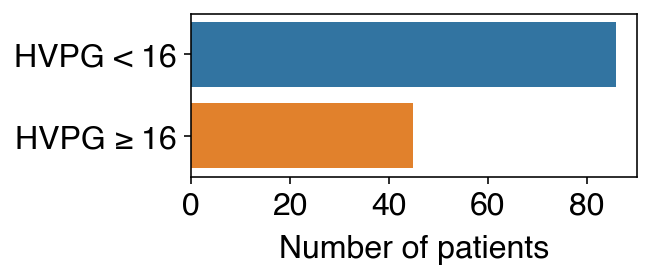

In [5]:
plt.figure(figsize=(4,1.5))
ax = sns.countplot(y = "HVPG_label", data = data)

#ax.set_xticklabels([""], fontsize=14)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

# x/y axis labels
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_xlabel("Number of patients", fontsize=16, labelpad=7)

plt.savefig("/Users/jreinis/Downloads/fig1/1A.pdf", bbox_inches="tight")
plt.show()

### Etiology distribution

In [6]:
etiologies = ["ALD", "VIRAL", "ALD+VIRAL", "NASH", "CHOL", "OTHER"]

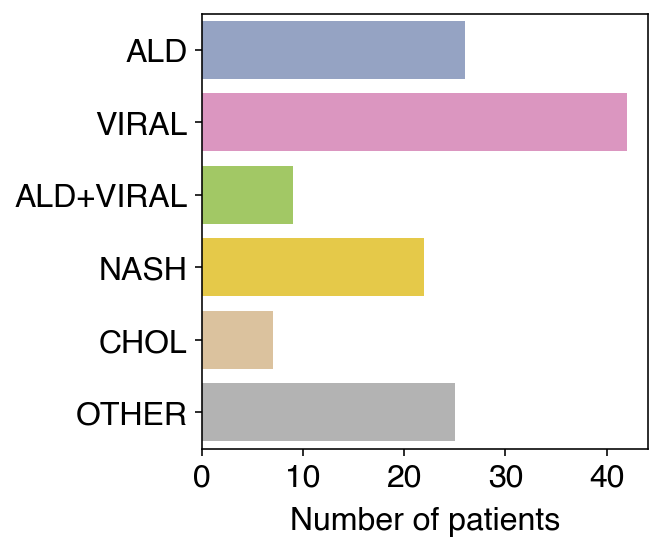

In [7]:
plt.figure(figsize=(4,4))
ax = sns.countplot(data=data, y="ETIO_Code", palette=sns.color_palette("Set2")[2:])

plt.xticks(fontsize=16)
ax.set_yticklabels(etiologies, fontsize=16)
ax.set_ylabel(None)
ax.set_xlabel("Number of patients", fontsize=16, labelpad=7)


plt.savefig("/Users/jreinis/Downloads/fig1/1B.pdf", bbox_inches="tight")
plt.show()

### 2A: correlations

In [8]:
# calculate correlations
correlations = data.corr(method="spearman")["HVPG"]

# top 10 positive and negative correlated params
top_correlations = pd.DataFrame(pd.concat([correlations.sort_values(ascending=False)[1:11], correlations.sort_values(ascending=True)[:10]])).reset_index(drop=False).sort_values(by="HVPG", ascending=False)

top_correlations.rename(columns={"index": "parameter", "HVPG": "correlation"}, inplace=True)

In [9]:
top_param_names = ["ELF", "Liver stiffness", "Bile acids", "INR", "Ammonia", "aPTT", "Bilirubin", "MELD", "GGT", "Placental growth factor",
                   "Hematocrit", "Magnesium", "Erythrocyte count", "Cholinesterase", "Platelets", "Albumin", "Vitamin A", "Prothrombin time", "AT-III", "Activated protein C"]
labels = [f"{par} ({val:.3f}) " for par,val in zip(top_param_names, top_correlations["correlation"])]

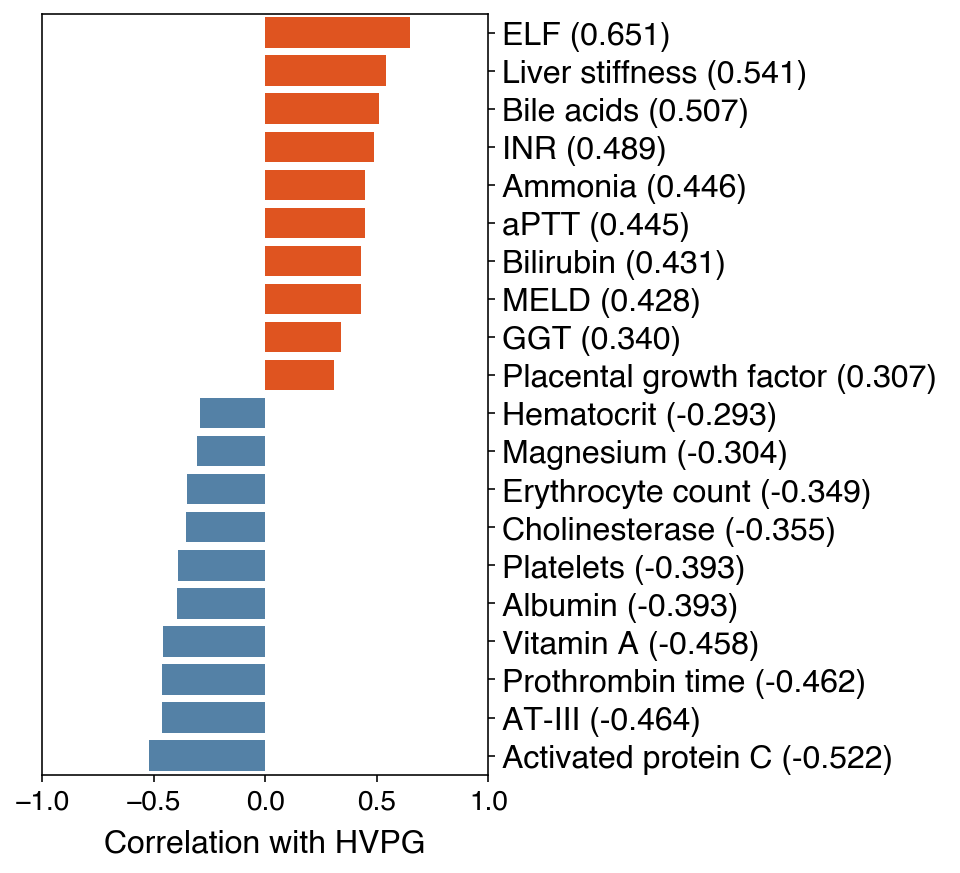

In [10]:
plt.figure(figsize=(4,7))
ax = sns.barplot(data=top_correlations,y="parameter", x="correlation", palette=["orangered" for _ in range(10)]+["steelblue" for _ in range(10)])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticklabels(labels, fontsize=16)
ax.set_ylabel(None)
plt.xlim(-1,1)
plt.xticks(fontsize=14)
plt.yticks(fontweight="bold")
plt.xlabel("Correlation with HVPG", fontweight="bold", fontsize=16,labelpad=7)
plt.savefig("/Users/jreinis/Downloads/fig1/1C.pdf", bbox_inches="tight")
plt.show()

### 2C: ROC curves from CV for 5/3-SW vs LSM

#### Load VICIS dataset from merged Excel file

In [11]:
preprocessed_data_path = "/Users/jreinis/OneDrive/Rotation/rotation/data_collaborators_updated_v3/merged_datasets_HVPG_strictly_compensated_center_names.csv"

In [12]:
data_all = pd.read_csv(preprocessed_data_path)[["dataset", "HVPG", "PLT", "BILI", "aPTT", "CHE", "GGT", "VCTE-LSM-kPa"]]
# call liver stiffness just LSM
data_all.rename(columns = {"VCTE-LSM-kPa":"LSM"}, inplace=True)

In [13]:
data = data_all.dropna().query('dataset=="VIENNA"')

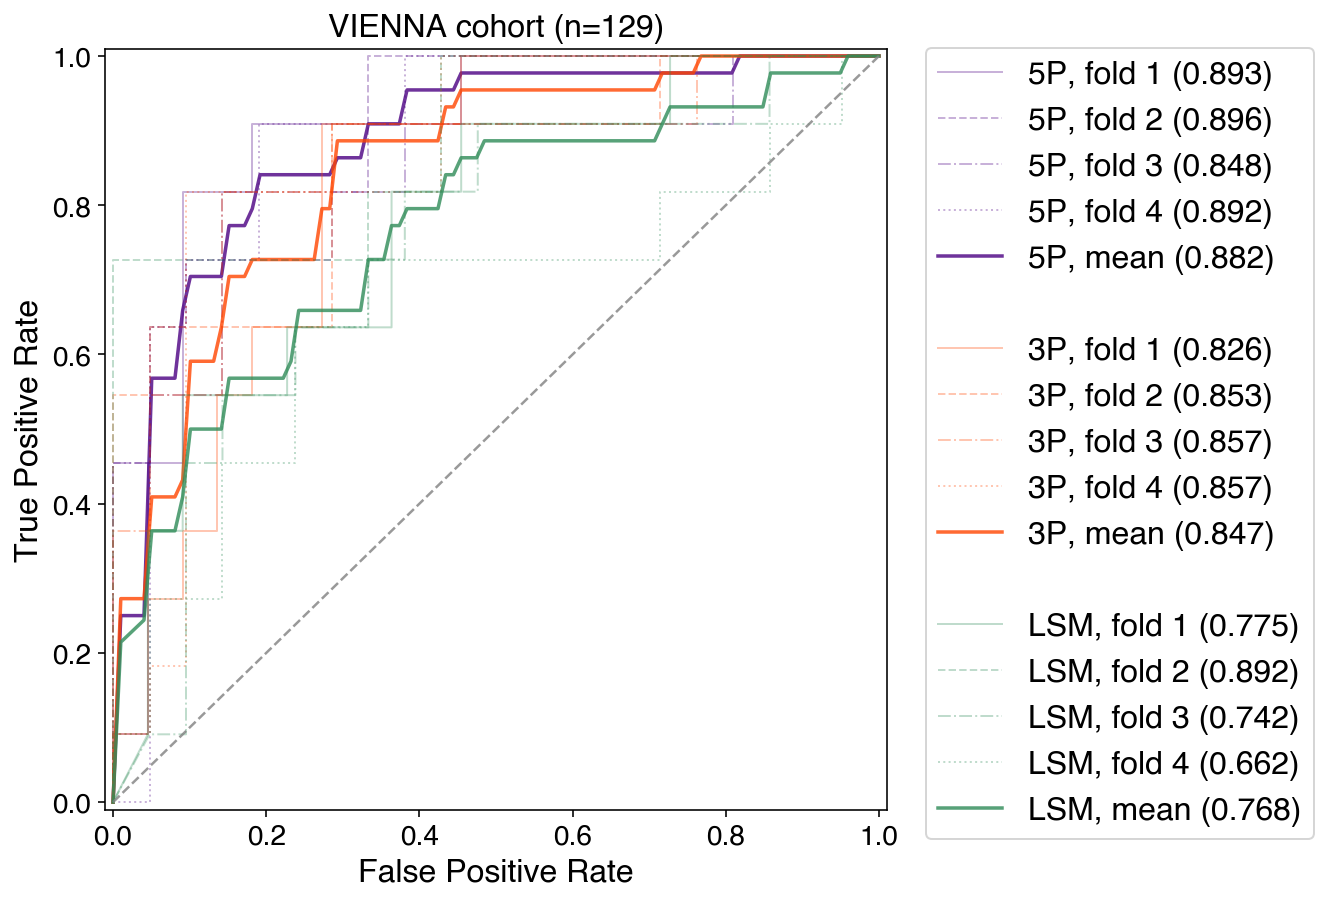

In [14]:
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=4422)
classifier = LogisticRegression(C=0.6, warm_start=False, max_iter=1000)

ax = plt.figure(figsize=(7,7))

X = data[["PLT", "BILI", "aPTT", "CHE", "GGT"]]
y = 1*(data["HVPG"] >= 16)
HVPG16_functions.plot_ROC_CV(classifier, cv, X, y, "indigo", "5P")

# trick to have space in the legend
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='white', label=' ', alpha=.8)

X = data[["PLT", "BILI", "aPTT"]]
y = 1*(data["HVPG"] >= 16)
HVPG16_functions.plot_ROC_CV(classifier, cv, X, y, "orangered", "3P")

# trick to have space in the legend
plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='white', label=' ', alpha=.8)

X = data[["LSM"]]
y = 1*(data["HVPG"] >= 16)
HVPG16_functions.plot_ROC_CV(classifier, cv, X, y, "seagreen", "LSM")

plt.plot([0, 1], [0, 1], linestyle='--', lw=1.25, color='grey', label='', alpha=.8)


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([-0.01, 1.01])

plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1.001), loc=2, borderaxespad=0.,prop={"size":16})
plt.title(f"VIENNA cohort (n={len(data)})", fontsize=16)
plt.savefig(output_folder_plots + "VIENNA_cohort_CV_comparison.pdf", bbox_inches="tight")
plt.show()